In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [3]:
cases = pd.read_csv("../data/canada/cases/Toronto_COVID19_cases.csv")
wastewater = pd.read_csv("../data/canada/covid19-wastewater.csv")

In [4]:
cases.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No
1,2,2,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,Yes,No,No
2,3,3,NO,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No
3,4,4,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No
4,5,5,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No


## Select relevant column(s): Only Neighbourhood Highland Creek

In [5]:
episode_cases = cases[cases["Neighbourhood Name"]=="Highland Creek"].copy().groupby("Episode Date").count()[["_id"]]
reported_cases = cases[cases["Neighbourhood Name"]=="Highland Creek"].copy().groupby("Reported Date").count()[["_id"]]

In [6]:
episode_cases = episode_cases.reset_index().rename({"Episode Date": "date"}, axis=1)
reported_cases = reported_cases.reset_index().rename({"Reported Date": "date"}, axis=1)

In [7]:
toronto_cases = pd.merge(episode_cases, reported_cases, on="date", how="outer")

In [8]:
toronto_cases = toronto_cases.rename({'_id_x': "cases_episode_date", 
                                      "_id_y": "cases_reported_date",
                                     "Episode Date": "date"}, axis=1)

In [9]:
toronto_cases

,date,cases_episode_date,cases_reported_date
0,2020-03-10,1.0,NaN
1,2020-03-11,1.0,NaN
2,2020-03-14,1.0,NaN
3,2020-03-19,1.0,NaN
4,2020-03-21,1.0,NaN
...,...,...,...
765,2023-05-14,NaN,1.0
766,2023-05-29,NaN,1.0
767,2023-06-03,NaN,1.0
768,2023-06-16,NaN,1.0


#### Question: Is it important whether we choose cases_episode_date or cases_reported_date?

In [10]:
toronto_cases["date"] = pd.to_datetime(toronto_cases["date"])

In [11]:
toronto_cases.sort_values("date", inplace=True)

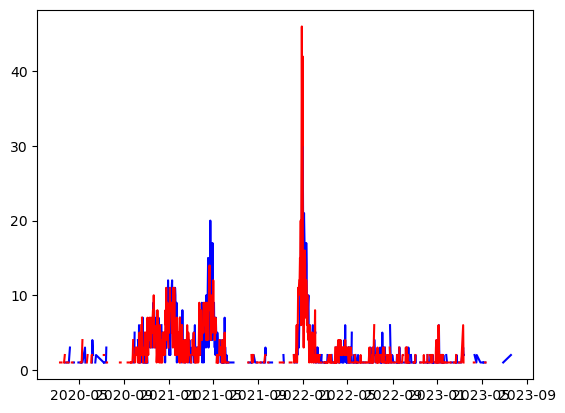

In [12]:
plt.plot(toronto_cases["date"], toronto_cases["cases_reported_date"], color="blue")
plt.plot(toronto_cases["date"], toronto_cases["cases_episode_date"], color="red")

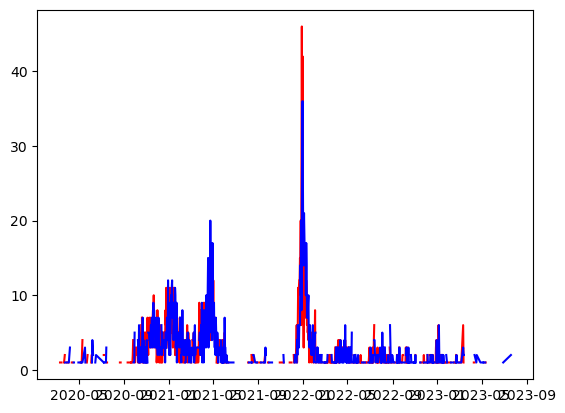

In [13]:
plt.plot(toronto_cases["date"], toronto_cases["cases_episode_date"], color="red")
plt.plot(toronto_cases["date"], toronto_cases["cases_reported_date"], color="blue")

Does not really look like it --> use reported date

### caluculate 7-day cases

incidence = cases*100 000 / (population*time) (pro 100 000) -> not implemented anymore

In [14]:
pop = 13000 # https://www.toronto.ca/ext/sdfa/Neighbourhood%20Profiles/pdf/2016/pdf1/cpa134.pdf

In [15]:
toronto_cases.head()

,date,cases_episode_date,cases_reported_date
0,2020-03-10,1.0,NaN
1,2020-03-11,1.0,NaN
2,2020-03-14,1.0,NaN
607,2020-03-18,NaN,1.0
3,2020-03-19,1.0,NaN


In [16]:
toronto_cases = toronto_cases.set_index("date").resample('D').mean()

In [17]:
toronto_cases["cases_7d"] = toronto_cases["cases_reported_date"].fillna(0).rolling(7, center=False, min_periods=1).mean() # /pop*100000

In [18]:
toronto_cases = toronto_cases[["cases_reported_date", "cases_7d"]]

In [19]:
toronto_cases["cases_7d"].describe()

count    1228.000000
mean        1.593881
std         2.736323
min         0.000000
25%         0.142857
50%         0.571429
75%         1.714286
max        23.857143
Name: cases_7d, dtype: float64

## Select relevant wastewater data

In [30]:
loc = "Toronto Highland Creek"

In [31]:
wastewater.head()

,Date,Location,region,measureid,fractionid,viral_load,seven_day_rolling_avg,pruid
0,2021-12-08,Montreal North,Montreal,covN2,solid,116.061020,75.756258,24
1,2021-12-11,Montreal North,Montreal,covN2,solid,33.467815,74.764417,24
2,2021-08-04,North Battleford,North Battleford,covN2,mixed,0.870000,0.870000,47
3,2021-08-06,North Battleford,North Battleford,covN2,mixed,0.000000,0.435000,47
4,2021-12-15,Montreal North,Montreal,covN2,solid,58.932050,46.199933,24


In [32]:
wastewater[wastewater["region"]=="Toronto"]["Location"].unique()

array(['Toronto Ashbridges Bay', 'Toronto Highland Creek',
       'Toronto Humber', 'Toronto North Toronto'], dtype=object)

In [33]:
wastewater_toronto = wastewater.loc[wastewater["Location"]== loc, ["Date", "viral_load", "seven_day_rolling_avg"]]

In [34]:
wastewater_toronto = wastewater_toronto.rename({"Date": "date", "seven_day_rolling_avg": "conc_7d_ravg"}, axis=1)

In [35]:
wastewater_toronto = wastewater_toronto.set_index("date") # /pop*1000

In [36]:
wastewater_toronto.describe()

,viral_load,conc_7d_ravg
count,243.000000,243.000000
mean,89.023132,88.463306
std,145.141245,126.510526
min,1.829155,2.767380
25%,18.268765,20.931400
50%,41.816770,46.874828
75%,107.754815,109.006129
max,1622.885535,1049.812675


## Merge

In [37]:
wastewater_toronto.reset_index(inplace=True)
wastewater_toronto["date"] = pd.to_datetime(wastewater_toronto["date"])

In [38]:
df_res = pd.merge(wastewater_toronto, toronto_cases.reset_index(), on="date")

In [39]:
df_res = df_res.fillna(0)

In [40]:
df_res["city"] = "Toronto"
df_res["district"] = "Highland_Creek"

In [41]:
df_res.to_csv("../data/preprocessed/canada.csv", index=False)

In [42]:
import seaborn as sns

In [43]:
dfm = df_res.melt('date', var_name='variable', value_name='vals')

In [44]:
df_plot = dfm[dfm["variable"].isin(['conc_7d_ravg', 'cases_7d'])]

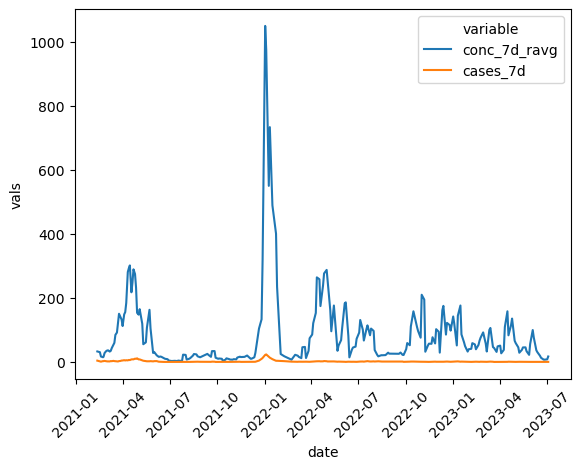

In [45]:
sns.lineplot(df_plot, x='date', y='vals', hue="variable")
plt.xticks(rotation=45)
plt.show()

In [46]:
df_res

,date,viral_load,conc_7d_ravg,cases_reported_date,cases_7d,city,district
0,2021-02-11,32.711260,32.711260,2.0,4.000000,Toronto,Highland_Creek
1,2021-02-16,28.145275,30.428268,4.0,1.714286,Toronto,Highland_Creek
2,2021-02-18,5.610275,16.877775,0.0,0.857143,Toronto,Highland_Creek
3,2021-02-22,10.307065,14.687538,2.0,2.571429,Toronto,Highland_Creek
4,2021-02-23,31.860865,15.926068,3.0,2.428571,Toronto,Highland_Creek
...,...,...,...,...,...,...,...
238,2023-06-20,9.490290,13.083222,0.0,0.142857,Toronto,Highland_Creek
239,2023-06-25,4.977585,7.233937,0.0,0.000000,Toronto,Highland_Creek
240,2023-06-27,9.184925,7.081255,0.0,0.000000,Toronto,Highland_Creek
241,2023-07-02,6.812985,7.998955,0.0,0.142857,Toronto,Highland_Creek
